In [1]:
# Sentiment algorithm 3. Sequence of lemmas and POS-tag as multiple features input and multi sentiment classification of sentence as output

# Model is saved in saved_models/model_name/model_variant.h5
# Run history is saved in logged_models/model_name sorted by model_variants and run-datetime
# Runs can be viewed using tensorboard: tensorboard --logdir=PATH --port=6006
# Example given: tensorboard --logdir=C:\BAC\Ezra\sentiment\models\logged_models\sent_algo_1 --port=6006
model_name = 'sent_algo_4'
model_variant = 'base'

training_size = 3000000
test_size = 1000000

In [2]:
# SETUP IMPORTS
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
import time
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from keras import callbacks
from keras import Input

%reload_ext autoreload
%autoreload 2
from helpers.sentiment_functions import gender_seq_to_single
from helpers.sentiment_functions import equal_genders
from helpers.sentiment_functions import encode_feature
from helpers.sentiment_functions import plot_sentence_lengths
from helpers.sentiment_functions import plot_confusion_matrix_multi
from helpers.sentiment_functions import get_metrics
from helpers.sentiment_functions import round_list
from helpers.sentiment_functions import encode_list
from helpers.sentiment_functions import one_hot_list
from helpers.sentiment_functions import xai_multi

pd.set_option('display.max_columns', 10, 'display.width', 10, 'display.max_colwidth', 20, 'display.max_rows',100)

In [3]:
# LOAD DATASET
df = pd.read_json('../datasets/sentiment_corpus.json')
print("Corpus sample size is:", len(df))

print(training_size, "samples are taken from the head for training")
print(test_size, "samples are taken from the tail for test")

# We take from the head for training data and tail for test data
# This is done since the last 25% of the corpus is not fitted on the polarity dict, thereby preventing overfitting
train_data = df.head(training_size)
test_data = df.tail(test_size)

train_data

Corpus sample size is: 4970467
3000000 samples are taken from the head for training
1000000 samples are taken from the tail for test


,Sentence #,Word,Lemma,POS,Polarity,Gender
0,1,organizations,organization,NOUN,-0.223025,F
1,1,decided,decide,VERB,-0.039008,F
2,1,drop,drop,VERB,-0.058436,F
3,1,women,woman,NOUN,0.272143,F
4,1,accused,accuse,VERB,0.006282,F
...,...,...,...,...,...,...
2999995,404384,cool,cool,ADJ,0.037064,F
2999996,404384,factors,factor,NOUN,-0.055300,F
2999997,404384,like,like,ADP,-0.129606,F
2999998,404384,pore,pore,NOUN,0.000000,F


In [4]:
# GROUP-BY SENTENCE NUMBER 
train_data = train_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))
test_data = test_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))

train_data['Gender'] = gender_seq_to_single(train_data['Gender'])
test_data['Gender'] = gender_seq_to_single(test_data['Gender'])
train_data

C:\Users\hanse\AppData\Local\Temp/ipykernel_3532/3370681660.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  train_data = train_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))
C:\Users\hanse\AppData\Local\Temp/ipykernel_3532/3370681660.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  test_data = test_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))


,Sentence #,Word,Lemma,POS,Polarity,Gender
0,1,"[organizations, ...","[organization, d...","[NOUN, VERB, VER...",[-0.223024829414...,F
1,2,"[Women, previous...","[woman, previous...","[NOUN, ADV, VERB...",[0.2721428399909...,F
2,3,"[response, alleg...","[response, alleg...","[NOUN, NOUN, PRO...",[-0.028053754978...,F
3,4,"[aware, allegati...","[aware, allegati...","[ADJ, NOUN, PROPN]",[-0.015715441394...,F
4,5,"[point, Visa, su...","[point, Visa, su...","[NOUN, PROPN, VE...",[-0.228729956550...,F
...,...,...,...,...,...,...
362024,404378,"[Philosophy, Hel...","[philosophy, hel...","[NOUN, VERB, NOUN]","[0.0, -0.2512493...",F
362025,404379,"[Philosophy, gem...","[Philosophy, gem...","[PROPN, NOUN, AD...","[0.0, 0.0, -0.19...",F
362026,404381,"[Benefit, POREfe...","[benefit, porefe...","[VERB, NOUN, NOU...",[-0.167289610994...,F
362027,404383,[Pores],[Pores],[PROPN],[0.0],F


In [5]:
# SHUFFLE TRAINING AND TEST DATA
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)
train_data

,Sentence #,Word,Lemma,POS,Polarity,Gender
0,25490,"[stuff, happened...","[stuff, happen, ...","[NOUN, VERB, NOU...",[0.0024807642824...,F
1,69438,"[cover, accompan...","[cover, accompan...","[NOUN, ADJ, NOUN...",[0.0416759581623...,F
2,95276,"[entered, joint,...","[enter, joint, v...","[VERB, ADJ, NOUN...",[-0.042968069846...,M
3,146249,"[introverted, ex...","[introverted, ex...","[ADJ, ADJ, NOUN,...","[0.0, 0.0, -0.12...",M
4,57172,"[meetings, began...","[meeting, begin,...","[NOUN, VERB, VER...",[-0.118973113766...,F
...,...,...,...,...,...,...
362024,30605,"[follow, Twitter...","[follow, Twitter...","[VERB, PROPN, PR...",[-0.132595713702...,M
362025,158279,"[problems, surfa...","[problem, surfac...","[NOUN, VERB, VER...",[-0.168219903785...,M
362026,307558,"[ve, pulling, ba...","[ve, pull, bandw...","[AUX, VERB, NOUN...","[0.0, -0.0135815...",M
362027,172040,"[video, fuel, fi...","[video, fuel, fi...","[NOUN, NOUN, NOU...",[-0.051315703385...,F


<AxesSubplot:>

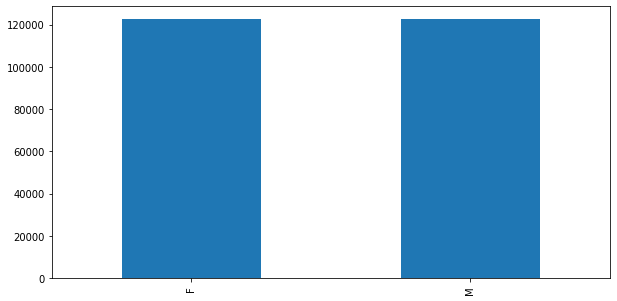

In [6]:
# EQUAL GENDER SAMPLES TO PREVENT BIAS
train_data = equal_genders(train_data)
test_data = equal_genders(test_data)

train_data["Gender"].value_counts().plot(kind="bar", figsize=(10,5))

No handles with labels found to put in legend.


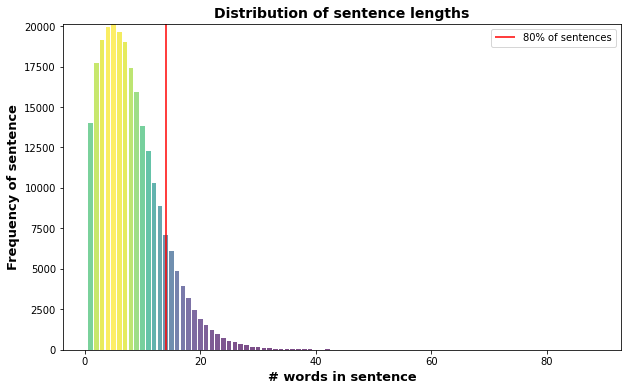

Decision boundary / 80 pct of sentence lengths is: 14


In [7]:
# VISUALIZE SENTENCE LENGTHS AND DECISION BOUNDARY
decision_boundary = plot_sentence_lengths(train_data)
print("Decision boundary / 80 pct of sentence lengths is:", decision_boundary)
decision_boundary = 15

In [8]:
# ONE-HOT TARGET (GENDER)
classes = [-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
n_unique_classes = len(classes)

pol_to_enc = {
    -1.0: 1,
    -0.9: 2,
    -0.8: 3,
    -0.7: 4,
    -0.6: 5,
    -0.5: 6,
    -0.4: 7,
    -0.3: 8,
    -0.2: 9,
    -0.1: 10,
    0.0: 11,
    0.1: 12,
    0.2: 13,
    0.3: 14,
    0.4: 15,
    0.5: 16,
    0.6: 17,
    0.7: 18,
    0.8: 19,
    0.9: 20,
    1.0: 21
}

train_pols_rounded = round_list(train_data['Polarity'])
train_pols_encoded = encode_list(train_pols_rounded, pol_to_enc)
y_train = one_hot_list(train_pols_encoded, n_unique_classes)

test_pols_rounded = round_list(test_data['Polarity'])
test_pols_encoded = encode_list(test_pols_rounded, pol_to_enc)
y_test = one_hot_list(test_pols_encoded, n_unique_classes)


print("Unique polarities:", [classes])
print("Unique polarities:", encode_list([classes], pol_to_enc))

print("\nTraining data example polarity sequence:", train_data['Polarity'][:1].tolist())
print("Training data example polarity sequence rounded:", train_pols_rounded[0])
print("Training data example polarity sequence encoded:", train_pols_encoded[0])
print("Training data example polarity sequence one-hot:", y_train[0])

print("\nTest data example polarity sequence:", test_data['Polarity'][:1].tolist())
print("Test data example polarity sequence rounded:", test_pols_rounded[0])
print("Test data example polarity sequence encoded:", test_pols_encoded[0])
print("Test data example polarity sequence one-hot:", y_test[0])

Unique polarities: [[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]]
Unique polarities: [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]]

Training data example polarity sequence: [[0.0024807642824230002, -0.08213922234331, -0.006139985883255, 0.0, -0.15489888489123202]]
Training data example polarity sequence rounded: [0.0, -0.1, -0.0, 0.0, -0.2]
Training data example polarity sequence encoded: [11, 10, 11, 11, 9]
Training data example polarity sequence one-hot: [array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 

In [9]:
# ENCODE FEATURES TO INTEGERS, EQUAL LENGTHS AND PAD
# Inspired by: https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/
train_data['Lemma_enc'], test_data['Lemma_enc'], vocab_size_lemma = encode_feature(train_data['Lemma'], test_data['Lemma'])
train_data['POS_enc'], test_data['POS_enc'], vocab_size_pos = encode_feature(train_data['POS'], test_data['POS'])

trunc_type = 'post'
padding_type = 'post'
max_len = decision_boundary

X_train_lemma = pad_sequences(train_data['Lemma_enc'], dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)
X_train_pos = pad_sequences(train_data['POS_enc'], dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)

X_test_lemma = pad_sequences(test_data['Lemma_enc'], dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)
X_test_pos = pad_sequences(test_data['POS_enc'], dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)

y_train = pad_sequences(y_train, dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)
y_test = pad_sequences(y_test, dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)

In [ ]:
# LOADING MODEL
from tensorflow import keras
model = keras.models.load_model('saved_models/sent_algo_4/base.h5')

In [ ]:
# PREDICT TEST DATA
y_pred = model.predict([X_test_lemma, X_test_pos])
cm_pred = y_pred.argmax(axis=-1).flatten()
cm_true = y_test.argmax(axis=-1).flatten()

In [ ]:
count = 0
for seq in test_data['Polarity'].to_numpy():
    count += len(seq)
count
print("test_data polarities length", count)
print("cm_pred shape", cm_pred.shape)
print("cm_true shape", cm_true.shape)
print("MEANING", cm_pred.shape[0]-count, "polarities are paddings")
print(cm_pred[:50])
print(cm_true[:50])

test_data polarities length 15662
cm_pred shape (28530,)
cm_true shape (28530,)
MEANING 12868 polarities are paddings
[10  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9 11 10 11 10  9  9  9  9
  9  9  9  9  9  9 11 11 10 11  9  9  9  9  9  9  9  9  9  9  9 11 11 11
 11 11]
[ 8  0  0  0  0  0  0  0  0  0  0  0  0  0  0 10 11 11 10 10  0  0  0  0
  0  0  0  0  0  0 11 11 11 10  9  0  0  0  0  0  0  0  0  0  0 11 11 11
 10 11]


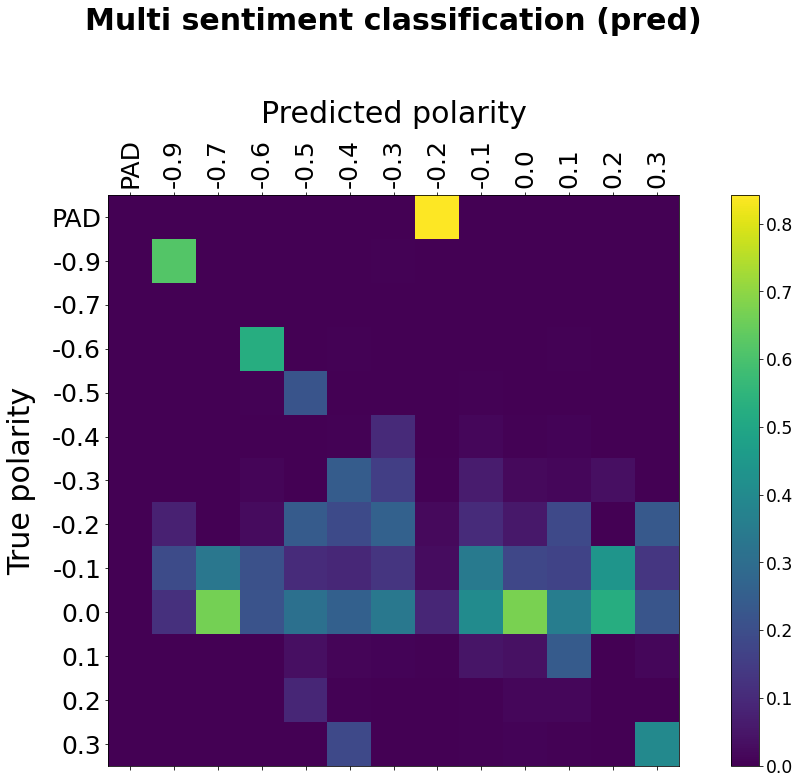

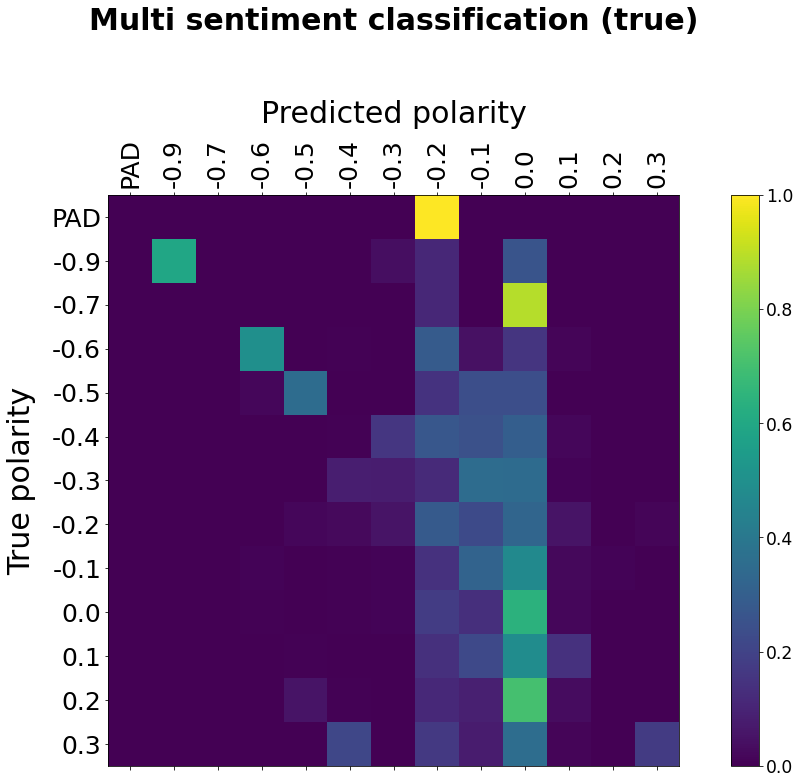

In [ ]:
# PLOTTING CONFUSION MATRIX
enc_to_pol = {
  0: "PAD",
  1 : -1.0,
  2 : -0.9,
  3 : -0.8,
  4 : -0.7,
  5 : -0.6,
  6 : -0.5,
  7 : -0.4,
  8 : -0.3,
  9 : -0.2,
  10 : -0.1,
  11 : 0.0,
  12 : 0.1,
  13 : 0.2,
  14 : 0.3,
  15 : 0.4,
  16 : 0.5,
  17 : 0.6,
  18 : 0.7,
  19 : 0.8,
  20 : 0.9,
  21 : 1.0,
}

plot_confusion_matrix_multi(cm_true, cm_pred, 'Multi sentiment classification', 'Predicted polarity', 'True polarity', enc_to_pol)

In [ ]:
# PRINTING METRICS
present_polarities = []

for x in np.unique(np.array(np.concatenate((cm_true,cm_pred)))):
    present_polarities.append(enc_to_pol[x])

get_metrics(cm_true, cm_pred, present_polarities, 'Polarity')

C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: Unde

,Polarity,precision,recall,f1-score,support
0,PAD,0.00,0.00,0.00,13834.0
1,-0.9,0.68,0.68,0.68,28.0
2,-0.7,0.57,0.73,0.64,11.0
3,-0.6,0.70,0.68,0.69,157.0
4,-0.5,0.50,0.57,0.53,54.0
5,-0.4,0.62,0.61,0.62,147.0
6,-0.3,0.70,0.71,0.70,511.0
7,-0.2,0.06,0.76,0.11,1282.0
8,-0.1,0.70,0.71,0.70,3074.0
9,0.0,0.87,0.69,0.77,8461.0


In [ ]:
# USE XAI ON PREDICTIONS
xai_multi(y_pred.argmax(axis=-1)[:500], test_data, 2, enc_to_pol)


---------------------------------------------------------------------------------------
The sentence: "Lesson #1: The truth is out there.".

Was predicted to be masculine (-0.2).

Most masculine words in sentence are:

'Lesson' with a polarity of 0.0
'truth' with a polarity of 0.0

---------------------------------------------------------------------------------------
The sentence: ""Whatever we see come out over the course of this year and the next year, the world is never going to go back to the way it was."".

Was predicted to be masculine (-0.2).

Most masculine words in sentence are:

'come' with a polarity of -0.2
'going' with a polarity of -0.2

---------------------------------------------------------------------------------------
The sentence: " Of course, such feelings of superiority are not justified from a moral point of view, and last night Azerbaijian took its revenge.".

Was predicted to be masculine (-0.2).

Most masculine words in sentence are:

'Azerbaijian' with a p